----------------------------
# **Creación del Modelo y Evalución**
------------------------ 

-------------------
------------------
## **1.** **Importar Librerias**
-------------------
------------------

In [24]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

-------------------
------------------
## **2.** **Cargar Datos Procesados**
-------------------
------------------

In [25]:
# Load Processed Data
movies_path = '../Data/Processed/processed_movies.csv'
movies = pd.read_csv(movies_path)

-------------------
------------------
## **3.** **Preprocesamiento de Emociones**
-------------------
------------------

In [26]:
# Emotion Preprocessing
movies['emotions_list'] = movies['emotions'].apply(lambda x: eval(x))

# Binarize the emotions
mlb = MultiLabelBinarizer()
emotions_binarized = mlb.fit_transform(movies['emotions_list'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(emotions_binarized, movies['average_rating'], test_size=0.2, random_state=42)

-------------------
------------------
## **4.** **Definir el Modelo**
-------------------
------------------

In [27]:
# Define the model
input_layer = Input(shape=(emotions_binarized.shape[1],))
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

-------------------
------------------
## **5.** **Entrenamiento del Modelo**
-------------------
------------------

In [28]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 2.7849 - mae: 0.8892 - val_loss: 0.6025 - val_mae: 0.4745
Epoch 2/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6944 - mae: 0.5732 - val_loss: 0.4471 - val_mae: 0.4767
Epoch 3/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5540 - mae: 0.5541 - val_loss: 0.4176 - val_mae: 0.4684
Epoch 4/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.5243 - mae: 0.5457 - val_loss: 0.4135 - val_mae: 0.4831
Epoch 5/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.5107 - mae: 0.5412 - val_loss: 0.4078 - val_mae: 0.4762
Epoch 6/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.4899 - mae: 0.5275 - val_loss: 0.4092 - val_mae: 0.4800
Epoch 7/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.4937 - mae: 0.5280 - val_loss: 0.4085 - val_mae: 0.4740
Epoch 8/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.4739 - mae: 0.5170 - val_loss: 0.4105 - val_mae: 0.4793
Epoch 9/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/

-------------------
------------------
## **6.** **Guardar el Modelo**
-------------------
------------------

In [29]:
model.save('../Models/movie_recommender_model_2.keras')

-------------------
------------------
## **7.** **Visualizar el Proceso de Entrenamiento**
-------------------
------------------

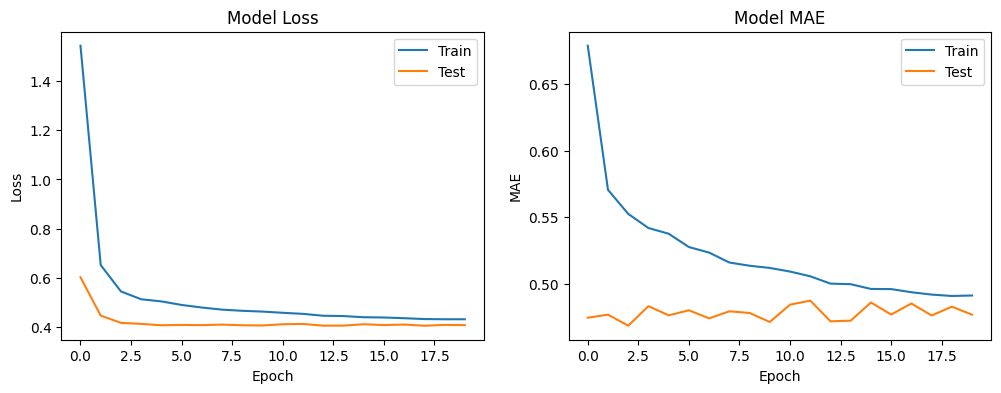

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

-------------------
------------------
## **8.** **Evaluación del Modelo**
-------------------
------------------

In [31]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}, Model MAE: {mae}')

# Calculate the mean value of y_test
y_test_mean = np.mean(y_test)

# Convert the loss to a percentage of the mean value of y_test
loss_percentage = (loss / y_test_mean) * 100

# Convert the MAE to a percentage of the mean value of y_test
mae_percentage = (mae / y_test_mean) * 100

print(f'Model Loss: {loss} ({loss_percentage:.2f}%)')
print(f'Model MAE: {mae} ({mae_percentage:.2f}%)')

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3986 - mae: 0.4715
Model Loss: 0.4083622395992279, Model MAE: 0.4767575263977051
Model Loss: 0.4083622395992279 (12.98%)
Model MAE: 0.4767575263977051 (15.15%)


-------------------
------------------
## **9.** **Función de Recomendación Mejorada**
-------------------
------------------

In [32]:
def recommend_movies_nn(emotion1, emotion2, movies=movies, mlb=mlb, model=model, top_n=10):
    emotions = [emotion1, emotion2]
    binarized_emotions = mlb.transform([emotions])
    predicted_rating = model.predict(binarized_emotions)[0][0]
    
    # Find movies with ratings close to the prediction
    movies['rating_diff'] = abs(movies['average_rating'] - predicted_rating)
    recommended_movies = movies.sort_values(by=['rating_diff', 'average_rating'], ascending=[True, False]).head(top_n)
    
    return recommended_movies[['title', 'average_rating']]

# Example recommendation
print("Recomendaciones para las emociones 'Anger' y 'Fear':")
print(recommend_movies_nn('Joy', 'Fear'))

Recomendaciones para las emociones 'Anger' y 'Fear':
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
                                   title  average_rating
796                          Fled (1996)        2.873468
4863  Affair of the Necklace, The (2001)        2.873418
3874                    Bedazzled (2000)        2.873602
8960                   Moonwalker (1988)        2.873239
6702                  Rookie, The (1990)        2.873750
2290               Money Pit, The (1986)        2.873938
691                          Boys (1996)        2.873950
4180                        Krull (1983)        2.872951
7118               Silencers, The (1966)        2.872340
1890              Friday the 13th (1980)        2.874771
